# Poisson disc sampling

Quality meshes are important for producing reliable solution in surface process modelling. For any given node in an unstructured mesh, its neighbours should be spaced more or less at an equal radius. For this we turn to Poisson disc sampling using an efficient $O(N)$ [algorithm](http://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf).

The premise of this algorithm is to ensure that points are tightly packed together, but no closer than a specified minimum distance. This distance can be uniform across the entire domain, or alternatively a 2D numpy array of radius lengths can be used to bunch and relax the spacing of nodes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

## Uniform spacing

3006 points


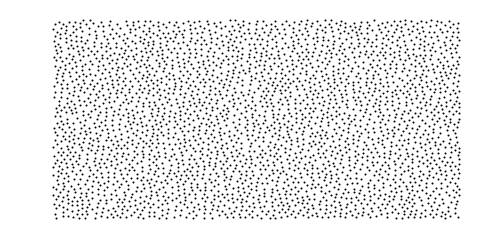

In [2]:
width, height = 800, 600
pts = meshtools.poisson_disc_sampler(width, height, radius=10.0)
print("{} points".format(pts.shape[0]))

fig = plt.figure(1, figsize=(8,4))
ax = fig.add_subplot(111)
ax.axis('off')
ax.scatter(pts[:,0], pts[:,1], s=1, c='k')
plt.show()

## Variable spacing

This is a *Poisson* disc sampler, so we sample fish...

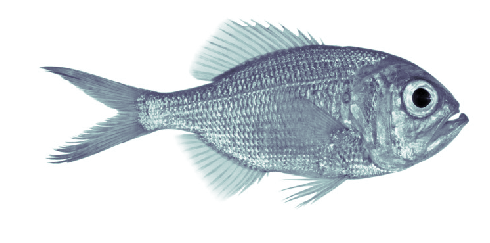

In [3]:
img = imread('data/fish.jpg', mode='F')
img = np.flipud(img)

height, width = img.shape

fig = plt.figure(1, figsize=(8,4))
ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(img, cmap='bone', origin='lower')
plt.show()

We adjust the numpy array to create sensible radii

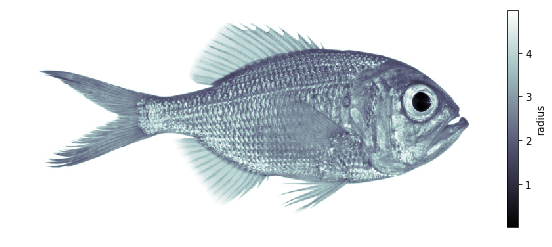

In [4]:
radius = img - img.min()
radius /= img.max()/5
radius += 1e-8

fig = plt.figure(1, figsize=(10,4))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow(radius, cmap='bone', origin='lower')
fig.colorbar(im, ax=ax, label='radius')
plt.show()

In [5]:
# weight.fill(10.)
pts = meshtools.poisson_disc_sampler(width, height, radius=None, r_grid=radius)
print("number of points is {}".format(pts.shape[0]))

number of points is 9854


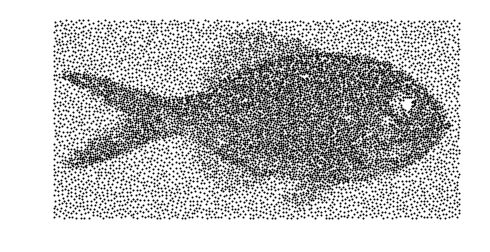

In [6]:
fig = plt.figure(1, figsize=(8,4))
ax = fig.add_subplot(111)
ax.axis('off')
ax.scatter(pts[:,0], pts[:,1], s=1, c='k')
plt.show()

### Landscape

In this example we create higher resolution where the slope is steeper.

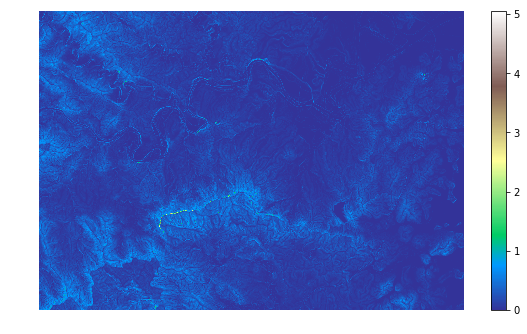

In [7]:
dem = imread('data/port_macquarie.tif', mode='F')

gradX, gradY = np.gradient(dem, 5., 5.) # 5m resolution in each direction
slope = np.hypot(gradX, gradY)

fig = plt.figure(1, figsize=(10,5.5))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow(slope, cmap='terrain')
fig.colorbar(im, ax=ax)

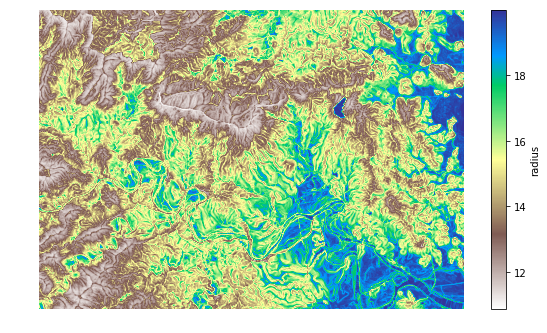

In [8]:
height, width = slope.shape

radius = 1./(slope + 0.1)
radius += 10

# apply gaussian filter for better results
from scipy.ndimage import gaussian_filter
radius = gaussian_filter(radius, 5.)

# radius -= slope.min()
# radius /= slope.max()/100
# radius += 1e-8

fig = plt.figure(1, figsize=(10,5.5))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow(radius, cmap='terrain_r', origin='lower')
fig.colorbar(im, ax=ax, label='radius')
plt.show()

number of points is 53262


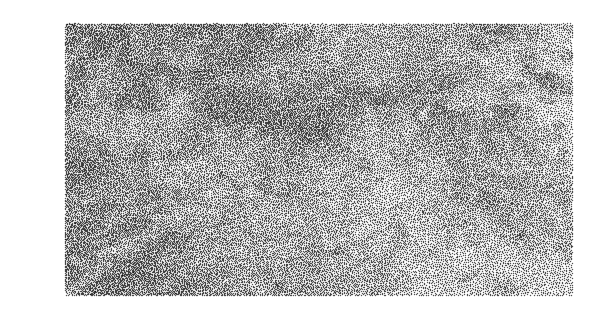

In [9]:
pts = meshtools.poisson_disc_sampler(width, height, radius=None, r_grid=radius)
print("number of points is {}".format(pts.shape[0]))

fig = plt.figure(1, figsize=(10,5.5))
ax = fig.add_subplot(111)
ax.axis('off')
ax.scatter(pts[:,0], pts[:,1], s=0.1, c='k')
plt.show()

Now the points can be triangulated to become a quality unstructured mesh.